In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import math
import random
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

In [18]:
class Node:
    """Class to represent a node in the RRT tree"""
    def __init__(self, x, y):
        self.x = x  # x-coordinate
        self.y = y  # y-coordinate
        self.parent = None  # parent node
        self.children = []  # list of child nodes
        self.cost = 0.0  # cost from start to this node
        
    def __repr__(self):
        return f"Node({self.x:.2f}, {self.y:.2f})"

In [20]:
class Obstacle:
    """Class to represent obstacles in the environment"""
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        
    def contains(self, point):
        """Check if a point is inside the obstacle"""
        x, y = point
        return (self.x <= x <= self.x + self.width and 
                self.y <= y <= self.y + self.height)
    
    def plot(self, ax, color='red'):
        """Plot the obstacle on the given axes"""
        rect = Rectangle((self.x, self.y), self.width, self.height, 
                         color=color, alpha=0.5)
        ax.add_patch(rect)

In [ ]:
## by myself
"""
- set a start position and a goal
- sample a random point
- find nearest neighboring node
- if the random point is outside of the step size of the nearest neighbor then set that as the point
- or else calculate a point that is towards the sampled point and away by the step size amount, this will be a new node
- check if this point is within an obstacle, if not, add it as a waypoint
- if the point is within a threshold distance of the goal, then the goal is reached
- end loop
"""

In [28]:
class RRTMyself():
    def __init__(self, max_iters=1000):
        self.max_iters = int(max_iters)
        self.step_size = 0.5
        self.goal_threshold = 0.5
        self.goal_bias = 0.1
        self.search_space = (-2, -2, 12, 12)  # x_min, y_min, x_max, y_max
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))

        self.nodes = []
        self.obstacles = []
        self.path = []
        
        # all the below will come from the grid size
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]

    
    def plot_tree(self, start_node, goal_node, final_path=False):
        """Visualize the RRT tree"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=10)
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=10)
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot the tree
        for node in self.nodes:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)
        
        # Plot the final path if requested
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=2)
        
        plt.title("RRT Path Planning")
        plt.draw()
        plt.pause(0.01)
    
    def build_path(self, node):
        """Build the path from start to goal"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order

    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
        
    def collision_free(self, from_node_x, from_node_y, to_node_x, to_node_y):
        """Check if path between nodes is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
                return False
        return True
    
    def line_intersects_obstacle(self, from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
        """Check if line segment intersects obstacle"""
        steps = 20
        for i in range(steps + 1):
            t = i / steps
            x = from_node_x + t * (to_node_x - from_node_x)
            y = from_node_y + t * (to_node_y - from_node_y)
            if obstacle.contains((x, y)):
                return True
        return False
        
    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def sample(self, goal_node):
        """Randomly sample a point in the search space"""
        # With goal_bias probability, sample the goal directly
        # if random.random() < self.goal_bias:
        #     return goal_node.x, goal_node.y
        
        # Otherwise sample uniformly in the search space
        # x_min, y_min, x_max, y_max = self.params.search_space
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return (x, y)

    def nearest_neighbor(self, point: tuple):
        #find the node that is a nearest neighbor to the point
        x, y = point
        min_distance = float('inf')
        the_node = None
        for node in self.nodes:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                the_node = node

        return the_node

    def steer(self, from_x, from_y, to_x, to_y):
        dx = to_x - from_x
        dy = to_y - from_y
        theta = math.atan2(dy, dx)
        
        new_x = from_x + self.step_size * math.cos(theta)
        new_y = from_y + self.step_size * math.sin(theta)
        
        return (new_x, new_y)
                
    def run(self, start_position: list, goal_position: list, visualize=False):
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        self.nodes.append(start_node)
        
        for i in range(0, self.max_iters):
            if i % 10 == 0 and visualize:
                self.plot_tree(start_node, goal_node)
                # pass
            point = self.sample(goal_node)
            x_point, y_point = point
            nearest_node = self.nearest_neighbor(point)

            the_point = self.steer(nearest_node.x, nearest_node.y, x_point, y_point)
            
            if not self.collision_free(nearest_node.x, nearest_node.y, the_point[0], the_point[1]):
                continue
            new_node = Node(the_point[0], the_point[1])
            new_node.parent = nearest_node
            new_node.cost = nearest_node.cost + self.euclid_distance(the_point[0], nearest_node.x, the_point[1], nearest_node.y)
            
            self.nodes.append(new_node)
            nearest_node.children.append(new_node)

            if self.euclid_distance(new_node.x, goal_node.x, new_node.y, goal_node.y) < self.goal_threshold:
                self.path = self.build_path(new_node)
                self.plot_tree(start_node, goal_node, final_path=True)
                return True, i

        return False, self.max_iters

    def run_with_map_config(self, map_config, visualize=False):
        """
        Wrapper: Sets up the environment and calls the core run method.
        """
        # 1. Reinitialize Class Variables based on Map Config
        self.search_space = map_config['bounds']
        self.obstacles = map_config['obstacles']
        self.nodes = [] # Clear previous tree
        
        # 2. Extract Start and Goal
        start = map_config['start']
        goal = map_config['goal']
        
        # 3. Call the core logic
        return self.run(start, goal, visualize=visualize)

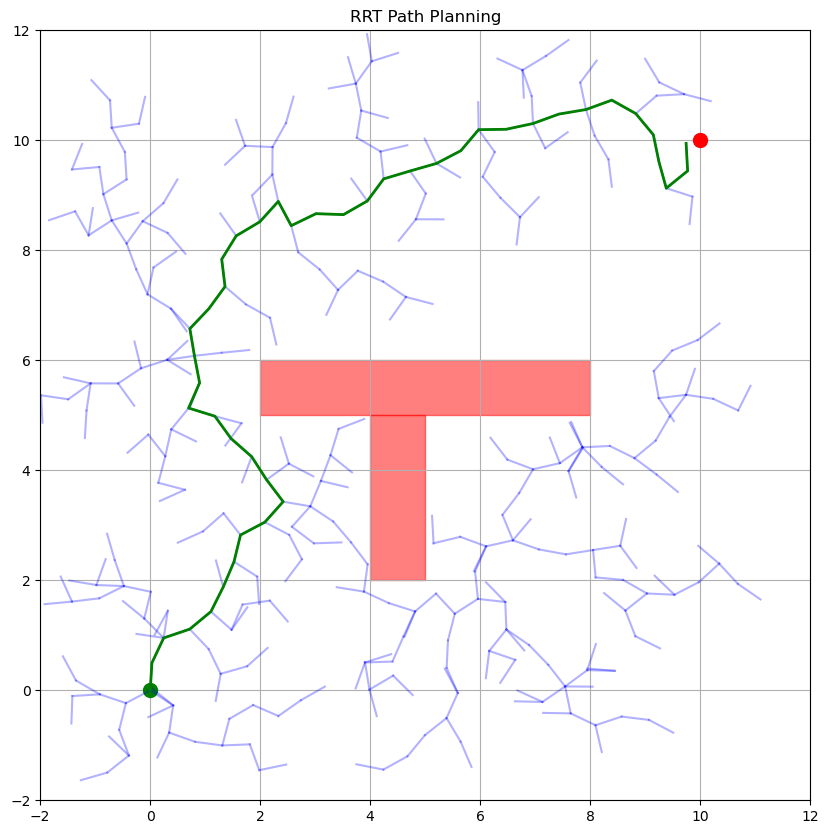

Path found in 453 iterations!
Path: [(0, 0), (0.03124144037022373, 0.49902301790958875), (0.24472928612681702, 0.951154569246375), (0.7183445882818255, 1.1114310352812238), (1.1032838616400986, 1.4305262496395788), (1.327276840396771, 1.8775465461225382), (1.5235005120154912, 2.3374337830583642), (1.641541475200765, 2.823300360433566), (2.083835582096757, 3.0564868158830127), (2.417108993181071, 3.429218399551778), (2.115255970638936, 3.8278219027754417), (1.8441739786026792, 4.247958253968307), (1.4686306808825127, 4.578060104216776), (1.1756120817317497, 4.983202178743386), (0.6981367792332638, 5.1315845749498745), (0.897723672967984, 5.5900222172190555), (0.8038568835815889, 6.0811322108562145), (0.7207928704870887, 6.5741843072199115), (1.0652232734142544, 6.936631127511427), (1.360034022538856, 7.3404709747288495), (1.2999571159369687, 7.8368486185577675), (1.562930635882282, 8.26210727844322), (1.992631014709072, 8.517758573053895), (2.3282937463343583, 8.88833991445933), (2.5639

In [58]:
rrt = RRTMyself()

obstacle_1 = Obstacle(4, 2, 1, 5)
rrt.add_obstacle(Obstacle(4, 2, 1, 3))
rrt.add_obstacle(Obstacle(2, 5, 6, 1))

success, iterations = rrt.run([0, 0], [10, 10])


if success:
    print(f"Path found in {iterations} iterations!")
    print("Path:", rrt.path)
    print("Path Length:", len(rrt.path))
else:
    print(f"Failed to find path after {iterations} iterations.")

In [31]:
## by myself
"""
- set a start position and a goal
- sample a random point
- find nearest neighboring node
- if the random point is outside of the step size of the nearest neighbor then set that as the point
- or else calculate a point that is towards the sampled point and away by the step size amount, this will be a new node
- check if this point is within an obstacle, if not, add it as a waypoint
- if the point is within a threshold distance of the goal, then the goal is reached
- end loop

possible ways to optimize
- dont sample random points, sample points close towards the goal but away from obstacles
- check is gradient is roughly the same, if so, use 1 point instead of many
"""

'\n- set a start position and a goal\n- sample a random point\n- find nearest neighboring node\n- if the random point is outside of the step size of the nearest neighbor then set that as the point\n- or else calculate a point that is towards the sampled point and away by the step size amount, this will be a new node\n- check if this point is within an obstacle, if not, add it as a waypoint\n- if the point is within a threshold distance of the goal, then the goal is reached\n- end loop\n\npossible ways to optimize\n- dont sample random points, sample points close towards the goal but away from obstacles\n- check is gradient is roughly the same, if so, use 1 point instead of many\n'

In [61]:
class RRTMeself():
    def __init__(self, max_iters=1000, search_space = (-2, -2, 12, 12)):
        self.max_iters = int(max_iters)
        self.step_size = 0.5
        self.goal_threshold = 0.5
        self.goal_probability = 1
        self.search_space = search_space # x_min, y_min, x_max, y_max
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))

        self.nodes = []
        self.obstacles = []
        self.path = []
        
        # all the below will come from the grid size
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]

    
    def plot_tree(self, start_node, goal_node, final_path=False):
        """Visualize the RRT tree"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=10)
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=10)
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot the tree
        for node in self.nodes:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)
        
        # Plot the final path if requested
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=2)
        
        plt.title("RRT Path Planning")
        plt.draw()
        plt.pause(0.01)
    
    def build_path(self, node):
        """Build the path from start to goal"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order
    
    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
        
    def collision_free(self, from_node_x, from_node_y, to_node_x, to_node_y):
        """Check if path between nodes is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
                return False
        return True
    
    def line_intersects_obstacle(self, from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
        """Check if line segment intersects obstacle"""
        steps = 20
        for i in range(steps + 1):
            t = i / steps
            x = from_node_x + t * (to_node_x - from_node_x)
            y = from_node_y + t * (to_node_y - from_node_y)
            if obstacle.contains((x, y)):
                return True
        return False
        
    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def sample(self, goal_node, obstacle_state=False):
        #select a random point within the grid size
        if obstacle_state == False:
            return goal_node.x, goal_node.y
        
        # if random.random() < self.goal_probability:
        #     return goal_node.x, goal_node.y
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return (x, y)

    def nearest_neighbor(self, point: tuple):
        #find the node that is a nearest neighbor to the point
        x, y = point
        min_distance = float('inf')
        the_node = None
        for node in self.nodes:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                the_node = node

        return the_node

    def steer(self, from_x, from_y, to_x, to_y):
        dx = to_x - from_x
        dy = to_y - from_y
        theta = math.atan2(dy, dx)
        
        new_x = from_x + self.step_size * math.cos(theta)
        new_y = from_y + self.step_size * math.sin(theta)
        
        return (new_x, new_y)
                
    def run_rrt(self, start_position: list, goal_position: list):
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        self.nodes.append(start_node)
        obstacle_state = False
        iterations = self.max_iters
        proto_path_found = False
        
        for i in range(0, self.max_iters):
            if i % 10 == 0:
                pass
                # self.plot_tree(start_node, goal_node)
            
            point = self.sample(goal_node)
            
            if obstacle_state == True:
                point = self.sample(goal_node, obstacle_state=obstacle_state)
                obstacle_state = False

            x_point, y_point = point
            nearest_node = self.nearest_neighbor(point)

            the_point = self.steer(nearest_node.x, nearest_node.y, x_point, y_point)
            
            if not self.collision_free(nearest_node.x, nearest_node.y, the_point[0], the_point[1]):
                obstacle_state = True
                # print(the_point)
                continue

            new_node = Node(the_point[0], the_point[1])
            new_node.parent = nearest_node
            new_node.cost = nearest_node.cost + self.euclid_distance(the_point[0], nearest_node.x, the_point[1], nearest_node.y)
            
            self.nodes.append(new_node)
            nearest_node.children.append(new_node)

            if self.euclid_distance(new_node.x, goal_node.x, new_node.y, goal_node.y) < self.goal_threshold:
                self.path = self.build_path(new_node)
                self.plot_tree(start_node, goal_node, final_path=True)
                iterations = i
                proto_path_found = True
                break

        # print(self.path) 
        
        return proto_path_found, iterations
                
            

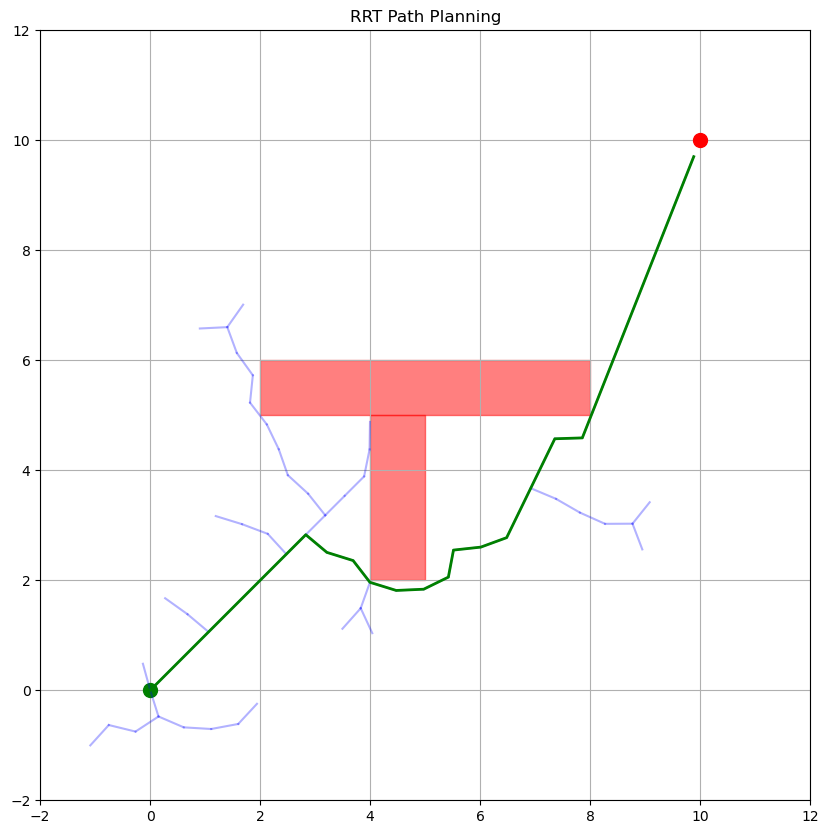

Path found in 133 iterations!
Path: [(0, 0), (0.3535533905932738, 0.35355339059327373), (0.7071067811865476, 0.7071067811865475), (1.0606601717798214, 1.0606601717798212), (1.4142135623730951, 1.414213562373095), (1.7677669529663689, 1.7677669529663687), (2.121320343559643, 2.1213203435596424), (2.474873734152917, 2.4748737341529163), (2.8284271247461907, 2.82842712474619), (3.211580752766834, 2.507189989074396), (3.6889389760088567, 2.3584313701536113), (3.9950098932115687, 1.9630573780364127), (4.472521693424872, 1.8147924777496276), (4.9720037598431945, 1.8375447375600686), (5.421003653375522, 2.0575426821140086), (5.513821997648408, 2.548851907517359), (6.010878045606283, 2.603030179808924), (6.480424546543818, 2.7748617352849703), (6.6993909710424715, 3.2243655783633978), (6.918357395541125, 3.6738694214418253), (7.137323820039778, 4.123373264520253), (7.356290244538431, 4.57287710759868), (7.85604086854195, 4.588666781695823), (8.04021161640538, 5.053512063086766), (8.22438236426

In [82]:
rrt = RRTMeself()

obstacle_1 = Obstacle(4, 2, 1, 5)
# rrt.obstacles.append(obstacle_1)
rrt.add_obstacle(Obstacle(4, 2, 1, 3))
rrt.add_obstacle(Obstacle(2, 5, 6, 1))

success, iterations = rrt.run_rrt([0, 0], [10, 10])


if success:
    print(f"Path found in {iterations} iterations!")
    print("Path:", rrt.path)
    print("Path Length:", len(rrt.path))
else:
    print(f"Failed to find path after {iterations} iterations.")